<a href="https://colab.research.google.com/github/cthmayo/eeg-preprocessing/blob/main/EEG_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alcoholic EEG Proprocessing

## Introduction


This project involves signal processing of electroencephalogram (EEG) signals sourced from a large [study](https://www.kaggle.com/nnair25/Alcoholics) involving 10 alcoholic subjects and 10 control subjects.

The aim of the project was to preprocess the EEG signals based on the preprocessing steps described in [this paper](https://pubs.asahq.org/anesthesiology/article/133/4/774/108256/Granger-Causality-of-the-Electroencephalogram).

## Imports and Downloads

In [ ]:
import zipfile
import numpy as np
import pandas as pd 
import os
import random
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
random.seed = 42

Download all the data...

In [ ]:
with zipfile.ZipFile('/content/Alcoholics.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')
filenames = sorted(os.listdir('/content/SMNI_CMI_TRAIN'))
df_eeg = pd.DataFrame()
for filename in tqdm_notebook(filenames):
  if filename != 'Train':
    df = pd.read_csv('/content/SMNI_CMI_TRAIN/'+filename)
    df_eeg = df_eeg.append(df)

## Data Processing

Some cleaning of an unused column and a unnecessary comma.

In [ ]:
df_eeg = df_eeg.drop(['Unnamed: 0'],axis=1)

In [ ]:
df_eeg.loc[df_eeg['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch'

Create a list of the EEG channel names (for reference).

In [ ]:
channel_names = np.asarray(df_eeg['sensor position'].value_counts().keys())
channel_names.sort()

A method to extract one EEG sample, given:
- a subject name (each of the 20 subjects has a unique ID)
- a matching condition (S1 obj, S2 match, or S2 nomatch)
- trial number
- a sensor position (optionally)

In [ ]:
def get_eeg(name, matching_condition, trial_number, sensor_position = None, source = df_eeg):
  df = source[(source['name'] == name)]
  df = df[df['matching condition'] == matching_condition]
  df = df[df['trial number'] == trial_number]
  if sensor_position == None:
    df = df.sort_values(['sensor position','time'])
    return df
  df = df[df['sensor position'] == sensor_position]
  return df['time'], df['sensor value']

A method to extract an EEG usign the above parameters and plot it.

In [ ]:
def see_eeg(name, matching_condition, trial_number, sensor_position = None, source = df_eeg):
  if sensor_position == None:
    g = sns.FacetGrid(get_eeg(name, matching_condition, trial_number, None, source),row='sensor position',height=1.7, aspect=4,)
    g.map(sns.lineplot, 'time', 'sensor value')
  else:
    sns.lineplot(*get_eeg(name, matching_condition, trial_number, sensor_position, source))

This method can extract single channel data...

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


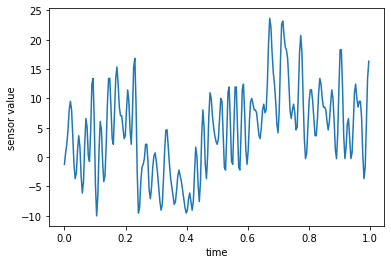

In [ ]:
see_eeg('co2a0000364','S1 obj',0, 'FPZ')

... and multiple channel data if required.

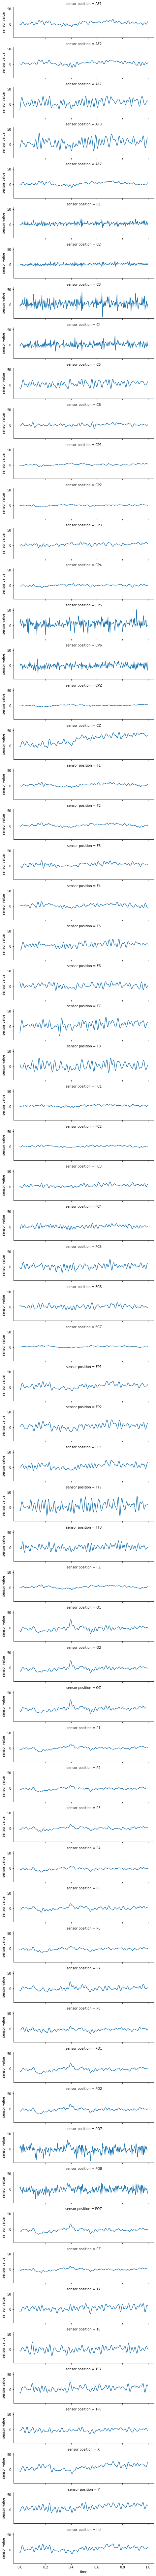

In [ ]:
see_eeg('co2a0000364','S1 obj',0)

There are two steps involved in preprocessing this data, in order to roughly replicate what was done in the published paper:
1. Downsample the signal to 125Hz.
2. Apply a Hyorth-type spacial filter.

### Downsampling

I will use the scipy.signal library in order to perform the downsampling.

In [ ]:
import scipy.signal as signal

In [ ]:
time, sensor_value = get_eeg('co2a0000364','S1 obj',0, 'FPZ')

Resampling is fairly trivial using this library...

In [ ]:
resampled_sensor_value, resampled_time = signal.resample(np.asarray(sensor_value), 125, np.asarray(time))

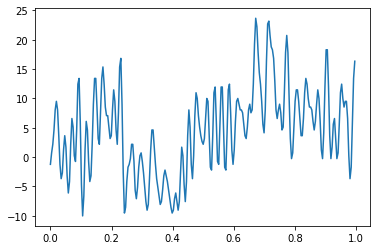

In [ ]:
plt.plot(time, sensor_value)

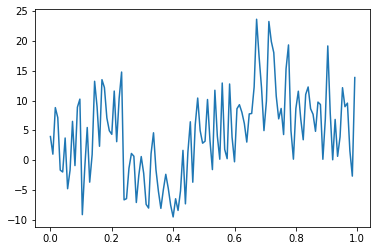

In [ ]:
plt.plot(resampled_time, resampled_sensor_value)

### Hjorth filter in order to decorrelate the multichannel EEG

I will perform the decorrelation based on [this paper](https://www.semanticscholar.org/paper/Decorrelation-of-multichannel-EEG-based-on-Hjorth-Liu-Sun/4ad6bd297a4e425792cae23b30eb53734a947f4c), which gives equations for a Hjorth spatial filter.

I must first determine the locations of each EEG channel. I found a file online that gave the approximate locations of where each EEG channel should be on the head.

In [ ]:
channels = pd.read_csv('ftp://sccn.ucsd.edu/pub/locfiles/eeglab/chan61fms11.loc', header=None, delim_whitespace=True, names = ['drop','theta','r','channel']).drop('drop',1)

Some processing of this file...

In [ ]:
# change angle to radians
channels['theta'] = 2 * np.pi * channels['theta'] / 360

In [ ]:
# polar to cartesian coordinates
channels['x'] = channels['r'] * np.sin(channels['theta'])
channels['y'] = channels['r'] * np.cos(channels['theta'])

Need to change the channel names so they're the same as the channel names used in the alcoholic EEG file.

In [ ]:
# fix up discrepancies
channels.loc[channels['channel'] == 'AF3', 'channel'] = 'AF1'
channels.loc[channels['channel'] == 'AF4', 'channel'] = 'AF2'
channels.loc[channels['channel'] == 'AFz', 'channel'] = 'AFZ'
channels.loc[channels['channel'] == 'CPz', 'channel'] = 'CPZ'
channels.loc[channels['channel'] == 'Cz', 'channel'] = 'CZ'
channels.loc[channels['channel'] == 'Oz', 'channel'] = 'OZ'
channels.loc[channels['channel'] == 'PO3', 'channel'] = 'PO1'
channels.loc[channels['channel'] == 'PO4', 'channel'] = 'PO2'
channels.loc[channels['channel'] == 'POz', 'channel'] = 'POZ'
channels.loc[channels['channel'] == 'Pz', 'channel'] = 'PZ'

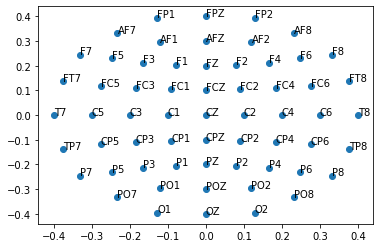

In [ ]:
fig, ax = plt.subplots()
plt.scatter(channels['x'],channels['y'])
for i, txt in enumerate(channels['channel']):
    ax.annotate(txt, (channels['x'][i], channels['y'][i]))

Need to define a value of epsilon, as well as a weight matrix in order to perform the Hjorth spatial filter.

In [ ]:
epsilon = 1e-07

In [ ]:
weight_matrix = {}
for channel1, x1, y1 in zip(channels['channel'], channels['x'], channels['y']):
  weight_matrix_constituent = {channel1+'-'+channel2: 1 / ((np.sqrt((x1 - x2)**2 + (y1 - y2)**2)) + epsilon) for channel2, x2, y2 in zip(channels['channel'], channels['x'], channels['y'])}
  weight_matrix.update(weight_matrix_constituent)

### Putting everything together

A big method to resample the signal to 125Hz and then perform a spatial filter.

In [ ]:
def resample_and_filter_sample(sample):
  
  # get details about the sample
  sample_name = sample['name']
  sample_condition = sample['matching condition']
  trial_number = sample['trial number']

  # cut channels that we don't know the location of
  sample = sample[sample['sensor position'] != 'X']
  sample = sample[sample['sensor position'] != 'Y']
  sample = sample[sample['sensor position'] != 'nd']

  # resample down to 125Hz
  df_resampled = pd.DataFrame()
  for channel_name in channel_names[:61]:
    eeg_channel = sample[sample['sensor position'] == channel_name]
    resampled_sensor_value, resampled_time = signal.resample(np.asarray(eeg_channel['sensor value']), 125, np.asarray(eeg_channel['time']))
    d = {'sensor position': [channel_name]*125, 'sensor value': resampled_sensor_value, 'time': resampled_time}
    df_resampled = df_resampled.append(pd.DataFrame(d))

  # get times
  times = np.asarray(df_resampled['time'].value_counts().keys().sort_values())

  # hjorth spatial filtering
  df_hjorthed = pd.DataFrame()
  for channel_name in tqdm_notebook(channel_names[:61]):
    for time in times:
      df_sensor_at_time = df_resampled[df_resampled['time'] == time].sort_values(by='sensor position')
      current_value = df_sensor_at_time[df_sensor_at_time['sensor position'] == channel_name]['sensor value']
      df_sensor_at_time = df_sensor_at_time[df_sensor_at_time['sensor position'] != channel_name]
      v = np.asarray(df_sensor_at_time['sensor value'])
      w = [weight_matrix['AF1-'+sensor] for sensor in df_sensor_at_time['sensor position']]
      p = np.dot(v,w) / np.linalg.norm(w, ord=1)
      g = current_value - p
      d = {'sensor position': channel_name, 'sensor value': g, 'time': time}
      df_hjorthed = df_hjorthed.append(pd.DataFrame(d))
  
  df_hjorthed['name'] = sample_name
  df_hjorthed['matching condition'] = sample_condition
  df_hjorthed['trial number'] = trial_number

  return df_hjorthed

Let's try the filter on this sample...

In [ ]:
sample_eeg = get_eeg('co2a0000364','S1 obj',0)

In [ ]:
sample_eeg_processed = resample_and_filter_sample(sample_eeg)

And now the final result: we can compare the two original EEG sample, and the processed EEG sample...

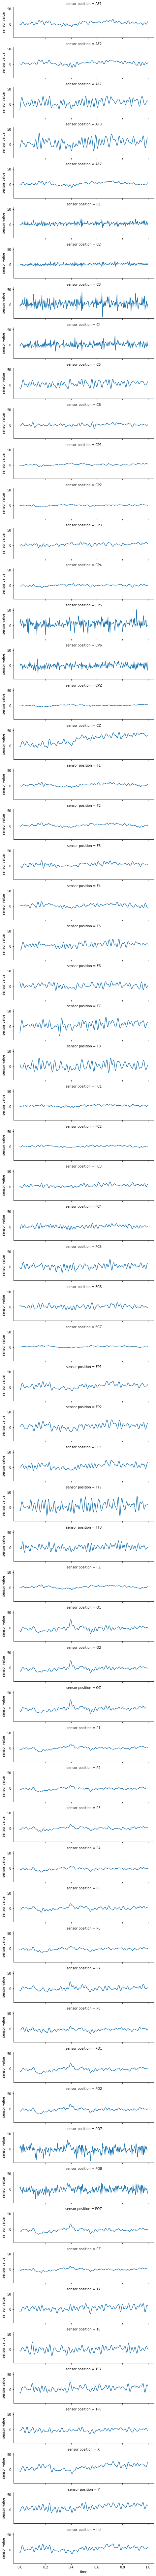

In [ ]:
see_eeg('co2a0000364','S1 obj',0)

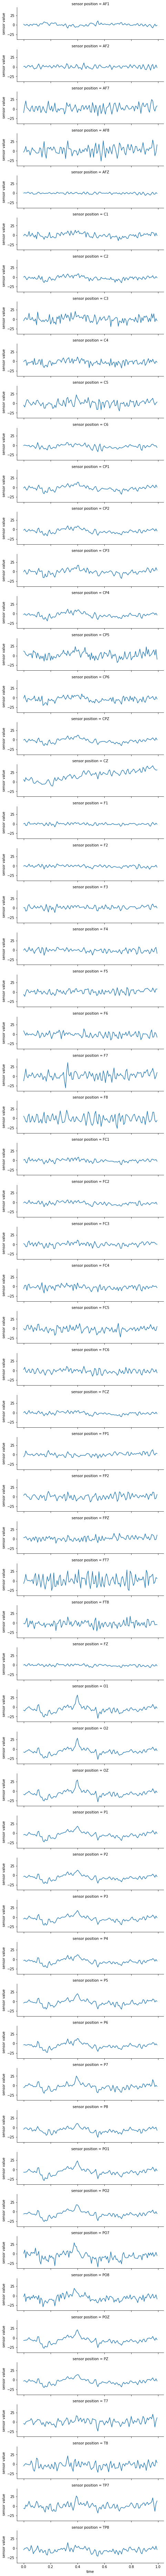

In [ ]:
see_eeg('co2a0000364','S1 obj',0, source=sample_eeg_processed)

## References

1. [ruslankl. EEG Data Analysis: Python notebook using data from EEG-Alcohol. Kaggle. 2019 Jan 5.](https://www.kaggle.com/ruslankl/eeg-data-analysis)
2. [Pullon RM, Yan L, Sleigh JW, Warnaby CE. Granger causality of the electroencephalogram reveals abrupt global loss of cortical information flow during propofol-induced loss of responsiveness. Anesthesiology. 2020 Oct 1;133(4):774-86.](https://pubs.asahq.org/anesthesiology/article/133/4/774/108256/Granger-Causality-of-the-Electroencephalogram)
3. [Liu Q, Sun M, Sclabassi RJ. Decorrelation of multichannel EEG based on hjorth filter and graph theory. In6th International Conference on Signal Processing, 2002. 2002 Aug 26 (Vol. 2, pp. 1516-1519). IEEE.](https://www.semanticscholar.org/paper/Decorrelation-of-multichannel-EEG-based-on-Hjorth-Liu-Sun/4ad6bd297a4e425792cae23b30eb53734a947f4c)
4. [An EEGLAB file found on the University of San Diego public FTP server](ftp://sccn.ucsd.edu/pub/locfiles/eeglab/chan61fms11.loc)